In [1]:
!pip install pytorch-forecasting --quiet
!pip install -U neptune --quiet
!pip install optuna-integration[pytorch_lightning] --quiet
!pip install loguru --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 14.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.4 MB/s eta 0:00:00


In [2]:
import optuna
type(optuna.pruners.NopPruner)

abc.ABCMeta

In [3]:
import os

from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer

import pickle
import numpy as np

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
#from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss

import tensorflow as tf
import tensorboard as tb
from lightning.pytorch.loggers import NeptuneLogger

import neptune
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhNzBiNTg2ZC1iZmVkLTQ3Y2UtOTY2MS1iNWQyN2JjNDI3MGEifQ==",  # replace with your own
    project="DeepLearning-adi/Energy-forecasting"
)
pl.seed_everything(42)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

INFO: Seed set to 42


42

In [4]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [6]:
tempdf=pd.read_csv('/kaggle/input/power-subregion-datastore2/datastore2/train/2022-10-01.csv')
tempdf

,period,subba,subba-name,parent,parent-name,value,value-units
0,2022-10-02T00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11070,megawatthours
1,2022-10-02T00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,12784,megawatthours
2,2022-10-02T00,SDGE,San Diego Gas and Electric - CISO,CISO,California Independent System Operator,1744,megawatthours
3,2022-10-02T00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,87,megawatthours
4,2022-10-02T00,COAS,ERCO - Coast,ERCO,"Electric Reliability Council of Texas, Inc.",13512,megawatthours
...,...,...,...,...,...,...,...
2045,2022-10-01T00,SPRM,City of Springfield - SWPP,SWPP,Southwest Power Pool,375,megawatthours
2046,2022-10-01T00,SPS,Southwestern Public Service Company - SWPP,SWPP,Southwest Power Pool,4230,megawatthours
2047,2022-10-01T00,WAUE,Western Area Power Upper Great Plains East - SWPP,SWPP,Southwest Power Pool,3621,megawatthours
2048,2022-10-01T00,WFEC,Western Farmers Electric Cooperative - SWPP,SWPP,Southwest Power Pool,1226,megawatthours


In [7]:
# Folder containing your CSV files
csv_folder = "/kaggle/input/power-subregion-datastore2/datastore2/train"

# Read and concatenate all CSV files
all_data = []
for file in sorted(os.listdir(csv_folder)):
    if file.endswith(".csv"):
        file_path = os.path.join(csv_folder, file)
        df = pd.read_csv(file_path)
        all_data.append(df)

# Combine all data into a single DataFrame
data = pd.concat(all_data, ignore_index=True)
print(data.head())

          period subba                           subba-name parent  \
0  2022-10-02T00  PGAE             Pacific Gas and Electric   CISO   
1  2022-10-02T00   SCE    Southern California Edison - CISO   CISO   
2  2022-10-02T00  SDGE    San Diego Gas and Electric - CISO   CISO   
3  2022-10-02T00   VEA  Valley Electric Association  - CISO   CISO   
4  2022-10-02T00  COAS                         ERCO - Coast   ERCO   

                                   parent-name  value    value-units  
0       California Independent System Operator  11070  megawatthours  
1       California Independent System Operator  12784  megawatthours  
2       California Independent System Operator   1744  megawatthours  
3       California Independent System Operator     87  megawatthours  
4  Electric Reliability Council of Texas, Inc.  13512  megawatthours  


In [8]:
# Extract date and hour
data['date'] = data['period'].str.split('T').str[0]
data['hour'] = data['period'].str.split('T').str[1]

# Group by date and parent-name to aggregate daily values
daily_data = data.groupby(['date', 'parent-name'], as_index=False)['value'].sum()
print(daily_data.head())


         date                                     parent-name    value
0  2022-10-01          California Independent System Operator   615943
1  2022-10-01     Electric Reliability Council of Texas, Inc.  1024579
2  2022-10-01                                 ISO New England   264681
3  2022-10-01  Midcontinent Independent System Operator, Inc.  1458161
4  2022-10-01            New York Independent System Operator   342332


In [9]:
# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])
daily_data['date'] = pd.to_datetime(daily_data['date'])

# Add week number column
daily_data['week'] = daily_data['date'].dt.isocalendar().week

# Group by week and parent-name to aggregate weekly values
weekly_data = daily_data.groupby(['week', 'parent-name'], as_index=False)['value'].sum()
print(weekly_data.head())


   week                                     parent-name     value
0     1          California Independent System Operator   8279198
1     1     Electric Reliability Council of Texas, Inc.  15442040
2     1                                 ISO New England   4770379
3     1  Midcontinent Independent System Operator, Inc.  25413247
4     1            New York Independent System Operator   5968098


In [10]:
# Add month column
daily_data['month'] = daily_data['date'].dt.month

# Group by month and parent-name to aggregate monthly values
monthly_data = daily_data.groupby(['month', 'parent-name'], as_index=False)['value'].sum()
print(monthly_data.head())


   month                                     parent-name      value
0      1          California Independent System Operator   36759646
1      1     Electric Reliability Council of Texas, Inc.   73351817
2      1                                 ISO New England   21666739
3      1  Midcontinent Independent System Operator, Inc.  117518510
4      1            New York Independent System Operator   27318340


In [11]:
# Split the DataFrame into a dictionary based on parent-name
parent_dict = {name: group for name, group in daily_data.groupby('parent-name')}

# Verify the split
for name, df in parent_dict.items():
    print(f"{name}: {len(df)} rows")


California Independent System Operator: 763 rows
Electric Reliability Council of Texas, Inc.: 763 rows
ISO New England: 763 rows
Midcontinent Independent System Operator, Inc.: 763 rows
New York Independent System Operator: 763 rows
PJM Interconnection, LLC: 763 rows
Public Service Company of New Mexico: 763 rows
Southwest Power Pool: 763 rows


In [12]:
for name, df in parent_dict.items():
    # Apply rolling average for smoothing
    df['value_smoothed'] = df['value'].rolling(window=7, center=True, min_periods=1).mean()

    # Replace the dictionary value with the updated DataFrame
    parent_dict[name] = df


In [13]:
for name, df in parent_dict.items():
    # Interpolate missing or anomalous values
    df['value_interpolated'] = df['value'].interpolate(method='linear')

    # Replace the dictionary value with the updated DataFrame
    parent_dict[name] = df


In [14]:
for name, df in parent_dict.items():
    # Calculate IQR for the group
    Q1 = df['value'].quantile(0.25)
    Q3 = df['value'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median
    df['value_cleaned'] = df['value'].apply(
        lambda x: df['value'].median() if x < lower_bound or x > upper_bound else x
    )

    # Replace the dictionary value with the updated DataFrame
    parent_dict[name] = df


In [15]:
# Combine all the updated DataFrames back into one
cleaned_data = pd.concat(parent_dict.values(), ignore_index=True)

# Verify the cleaned data
# print(cleaned_data.head())


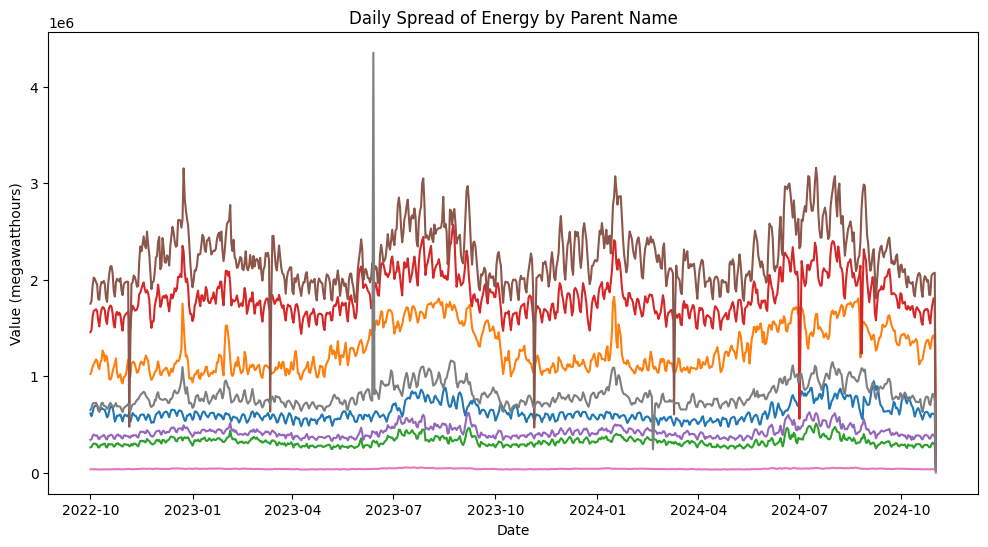

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cleaned_data, x='date', y='value', hue='parent-name')
plt.title('Daily Spread of Energy by Parent Name')
plt.xlabel('Date')
plt.ylabel('Value (megawatthours)')
plt.legend(title='Parent Name')
legend = plt.legend()
legend.remove()  # Remove the legend
plt.show()


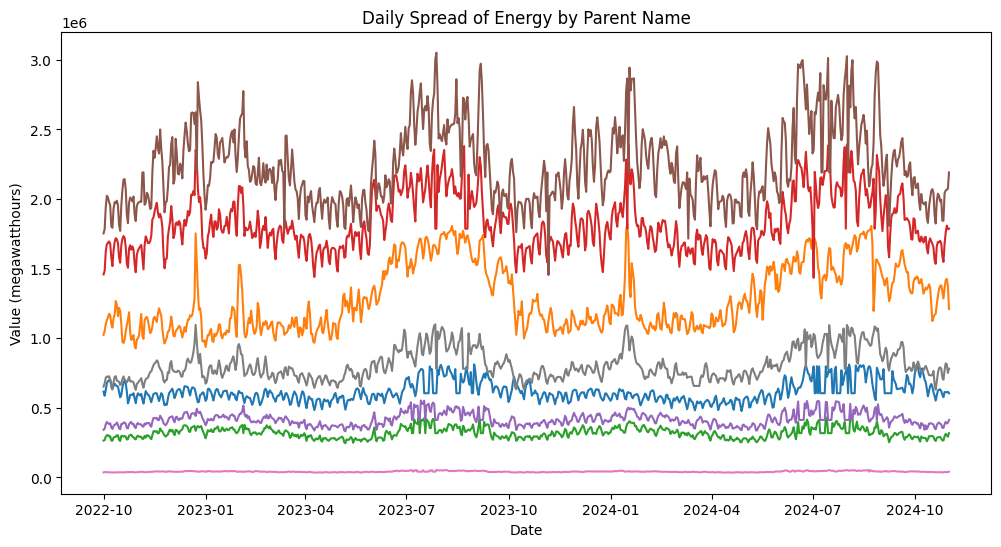

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=cleaned_data, x='date', y='value_cleaned', hue='parent-name')
plt.title('Daily Spread of Energy by Parent Name')
plt.xlabel('Date')
plt.ylabel('Value (megawatthours)')
plt.legend(title='Parent Name')
legend = plt.legend()
legend.remove()  # Remove the legend
plt.show()


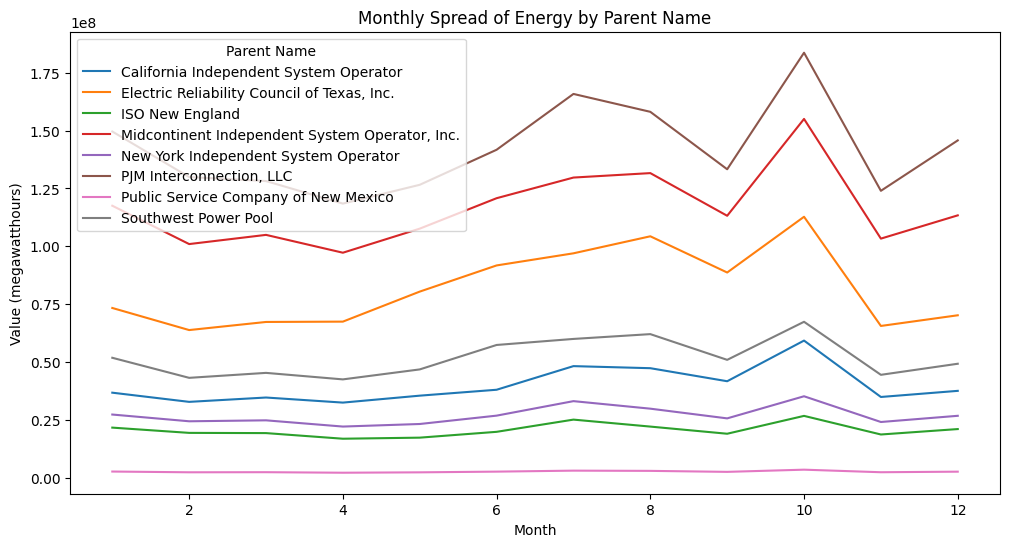

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data, x='month', y='value', hue='parent-name')
plt.title('Monthly Spread of Energy by Parent Name')
plt.xlabel('Month')
plt.ylabel('Value (megawatthours)')
plt.legend(title='Parent Name')
plt.show()


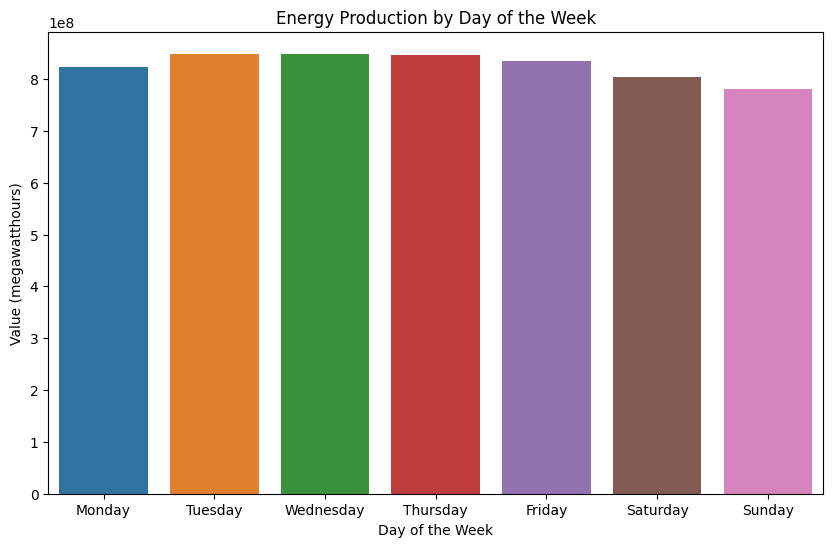

In [20]:
# Add day of the week column
daily_data['day_of_week'] = daily_data['date'].dt.day_name()

# Group by day of the week
day_of_week_data = daily_data.groupby('day_of_week', as_index=False)['value'].sum()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=day_of_week_data, x='day_of_week', y='value', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Energy Production by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Value (megawatthours)')
plt.show()


## Creating TimeseriesDataSet

### Splitting and Melting to create features

In [21]:
# Assume cleaned_data is your processed DataFrame with 'date', 'parent-name', and 'value_cleaned'

# Step 1: Sort the data and set up time features
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])
cleaned_data.sort_values(['parent-name', 'date'], inplace=True)

# Establish the earliest time for relative calculations
earliest_time = cleaned_data['date'].min()

# Create a list to hold all group data
df_list = []

# Iterate through each parent-name (group)
for name, group in cleaned_data.groupby('parent-name'):
    group = group.copy()
    date = group['date']

    # Add time-based features
    group['hours_from_start'] = (date - earliest_time).dt.total_seconds() // 3600
    group['hours_from_start'] = group['hours_from_start'].astype('int')

    group['days_from_start'] = (date - earliest_time).dt.days
    group['hour'] = date.dt.hour  # Hour of day
    group['day'] = date.dt.day  # Day of month
    group['day_of_week'] = date.dt.dayofweek  # Day of week
    group['month'] = date.dt.month  # Month

    # Add a 'parent_name' column as the group identifier
    group['parent_name'] = name

    # Rename target column to 'power_usage'
    group = group.rename(columns={'value_cleaned': 'power_usage'})

    df_list.append(group)

# Combine all groups into one DataFrame
time_df = pd.concat(df_list).reset_index(drop=True)

# Verify the data
print(time_df.head())


        date                             parent-name   value  week  month  \
0 2022-10-01  California Independent System Operator  615943    39     10   
1 2022-10-02  California Independent System Operator  587085    39     10   
2 2022-10-03  California Independent System Operator  628499    40     10   
3 2022-10-04  California Independent System Operator  677769    40     10   
4 2022-10-05  California Independent System Operator  691501    40     10   

   value_smoothed  value_interpolated  power_usage  hours_from_start  \
0   627324.000000              615943     615943.0                 0   
1   640159.400000              587085     587085.0                24   
2   650005.166667              628499     628499.0                48   
3   657182.428571              677769     677769.0                72   
4   665793.285714              691501     691501.0                96   

   days_from_start  hour  day  day_of_week  \
0                0     0    1            5   
1           

In [22]:
time_df.sort_values("days_from_start").groupby("parent-name").days_from_start.diff().dropna() == 1

2290    True
1527    True
1       True
764     True
3816    True
        ... 
5340    True
2288    True
3051    True
1525    True
762     True
Name: days_from_start, Length: 6096, dtype: bool

In [23]:
# Check if all groups have continuous and non-missing days_from_start
group_missing_check = (
    time_df.groupby("parent_name")
    .apply(lambda x: x["days_from_start"].is_monotonic_increasing and not x["days_from_start"].isnull().any())
)

print("Groups with missing or non-monotonic time steps:")
print(group_missing_check[~group_missing_check])


Groups with missing or non-monotonic time steps:
Series([], dtype: bool)


In [24]:
# Check the maximum and minimum days_from_start
print("Max days_from_start:", time_df["days_from_start"].max())
print("Min days_from_start:", time_df["days_from_start"].min())
max_encoder_length = 60  # Look back 60 time steps (days)
max_prediction_length = 14  # Predict 14 time steps (days)

# Print the cutoff value
training_cutoff = time_df["days_from_start"].max() - max_prediction_length
print(f"Training cutoff: {training_cutoff}")

# Check how much data remains after cutoff
remaining_data = time_df[time_df["days_from_start"] <= training_cutoff]
print("Remaining data after cutoff:")
print(remaining_data["parent_name"].value_counts())


Max days_from_start: 762
Min days_from_start: 0
Training cutoff: 748
Remaining data after cutoff:
parent_name
California Independent System Operator            749
Electric Reliability Council of Texas, Inc.       749
ISO New England                                   749
Midcontinent Independent System Operator, Inc.    749
New York Independent System Operator              749
PJM Interconnection, LLC                          749
Public Service Company of New Mexico              749
Southwest Power Pool                              749
Name: count, dtype: int64


In [25]:
# Check if each group has enough data points
required_length = max_encoder_length + max_prediction_length
group_lengths = time_df.groupby("parent_name")["days_from_start"].nunique()

print("Groups with insufficient lengths:")
print(group_lengths[group_lengths < required_length])


Groups with insufficient lengths:
Series([], Name: days_from_start, dtype: int64)


In [26]:
# Reindex each group to ensure continuous time steps
import pandas as pd

# Create a complete range of time steps for each group
full_time_range = (
    time_df.groupby("parent_name")
    .apply(lambda x: x.set_index("days_from_start").reindex(range(x["days_from_start"].min(), x["days_from_start"].max() + 1)))
    .drop("parent_name", axis=1)
    .reset_index()
)

# Fill missing values (forward fill for simplicity)
full_time_range = full_time_range.ffill().bfill()
full_time_range.rename(columns={"index": "days_from_start"}, inplace=True)

# Verify
print(full_time_range.head())
time_df = full_time_range


                              parent_name  days_from_start       date  \
0  California Independent System Operator                0 2022-10-01   
1  California Independent System Operator                1 2022-10-02   
2  California Independent System Operator                2 2022-10-03   
3  California Independent System Operator                3 2022-10-04   
4  California Independent System Operator                4 2022-10-05   

                              parent-name   value  week  month  \
0  California Independent System Operator  615943    39     10   
1  California Independent System Operator  587085    39     10   
2  California Independent System Operator  628499    40     10   
3  California Independent System Operator  677769    40     10   
4  California Independent System Operator  691501    40     10   

   value_smoothed  value_interpolated  power_usage  hours_from_start  hour  \
0   627324.000000              615943     615943.0                 0     0   
1   6401

In [27]:
# Define safe lags
lags = {"power_usage": [1, 2, 3, 7]}  # Lagging 1, 2, 3, and 7 days back

# Create the TimeSeriesDataSet
training = TimeSeriesDataSet(
    time_df[lambda x: x.days_from_start <= training_cutoff],
    time_idx="days_from_start",
    target="power_usage",
    group_ids=["parent_name"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["parent_name"],
    time_varying_known_reals=["days_from_start", "day", "day_of_week", "month", "hour"],
    time_varying_unknown_reals=["power_usage"],
    lags=lags,  # Add lags here
    target_normalizer=GroupNormalizer(groups=["parent_name"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)
print("Training dataset with lags created successfully!")


Training dataset with lags created successfully!


In [28]:
# Create the validation dataset
validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# Create DataLoaders
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=3)

In [29]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cuda")
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-29-ad32b3e0db50>:2: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss'

52282.51171875

In [30]:
from lightning.pytorch.tuner import Tuner

trainer = pl.Trainer(
    accelerator='gpu', 
    devices=1,
    gradient_clip_val=0.1,
)

net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
   hidden_size=30,
    rnn_layers=2,
    #loss=MultivariateNormalDistributionLoss(rank=30)
)
tuner = Tuner(trainer)
LR_results=tuner.lr_find(net, train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/deepar/__init__.py:146: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epo

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.009999999999999997
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_e52f0705-571b-4e44-973e-2566d79d373c.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_e52f0705-571b-4e44-973e-2566d79d373c.ckpt


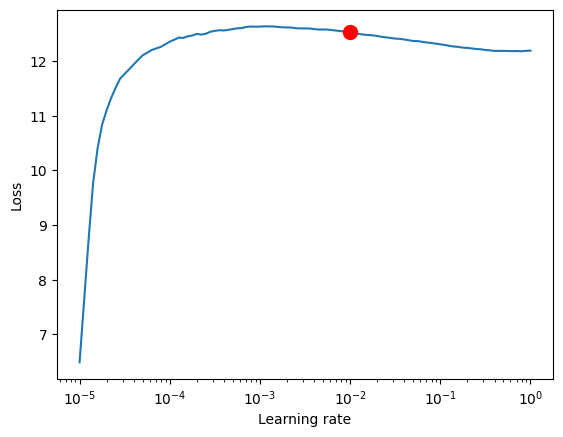

In [31]:
fig = LR_results.plot(show=True, suggest=True)
fig.show()

In [32]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=5, verbose=True, mode="min")
#lr_logger = LearningRateMonitor()  
# logger = TensorBoardLogger("lightning_logs")  
# {'gradient_clip_val': 0.6083678399431233, 'hidden_size': 111, 'dropout': 0.18597349678623726, 'hidden_continuous_size': 59, 'attention_head_size': 3, 'learning_rate': 0.04131023884248371}
trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.6,
    #callbacks=[lr_logger],
     callbacks=[early_stop_callback],
     enable_checkpointing=True,
    logger=neptune_logger)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [33]:
net = DeepAR.from_dataset(
    training,
    learning_rate=0.7,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    #loss=MultivariateNormalDistributionLoss(rank=30),
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/deepar/__init__.py:146: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in defau

In [34]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/DeepLearning-adi/Energy-forecasting/e/EN-7


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name                   | Type                   | Params | Mode 
--------------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList             | 0      | train
2 | embeddings             | MultiEmbedding         | 40     | train
3 | rnn                    | LSTM                   | 13.6 K | train
4 | distribution_projector | Linear                 | 62     | train
--------------------------------------------------------------------------
13.7 K    Trainable params
0         Non-trainable params
13.7 K    Total params
0.055     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 13.330


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 90.0


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.894 >= min_delta = 1e-05. New best score: 12.436


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 181.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 272.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 363.0


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.133 >= min_delta = 1e-05. New best score: 12.303


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 454.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 545.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 636.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 727.0


Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 818.0


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 12.303. Signaling Trainer to stop.


In [35]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [36]:
# Predict raw (unnormalized) values, return x = time step
raw_predictions,x,encoder_cont,encoder_target, var5 = best_model.predict(val_dataloader, mode="raw", return_x=True)


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 909.0


In [37]:
raw_predictions=best_model.predict(val_dataloader, mode="raw", return_x=True)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [38]:

#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)



('prediction',)


torch.Size([8, 14, 100])


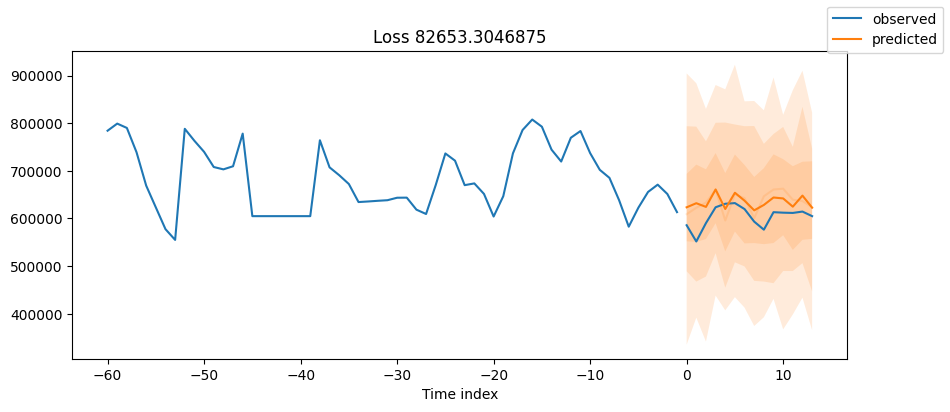

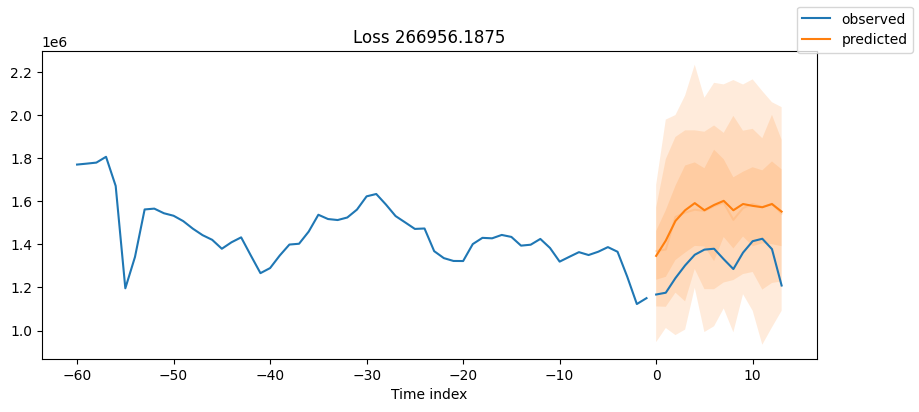

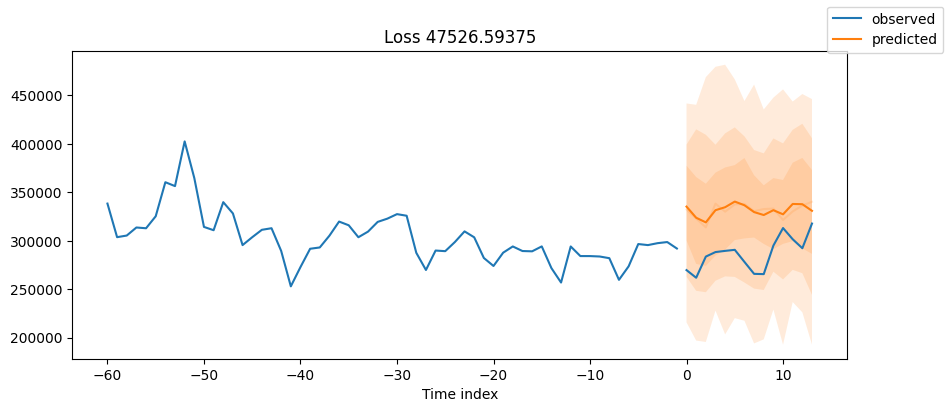

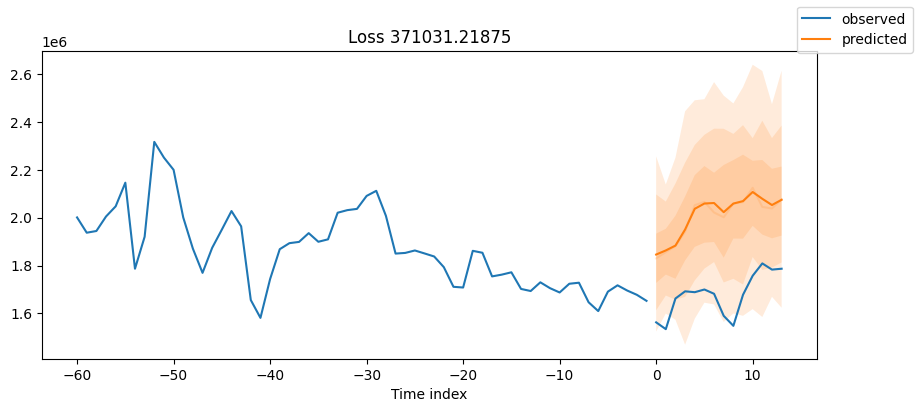

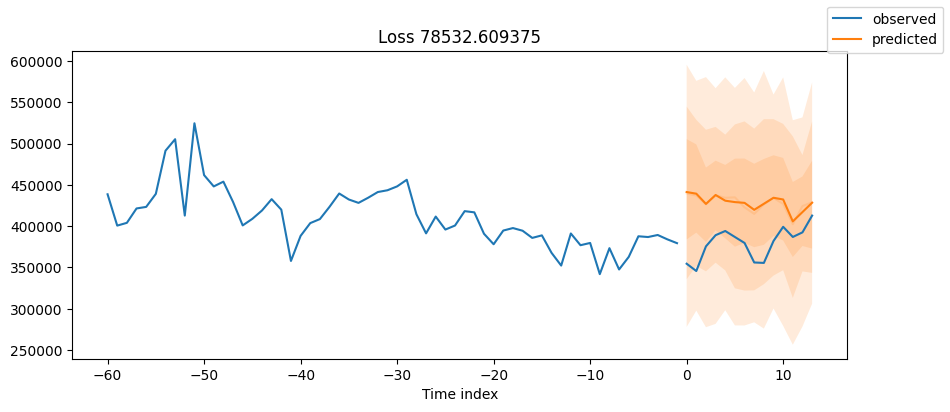

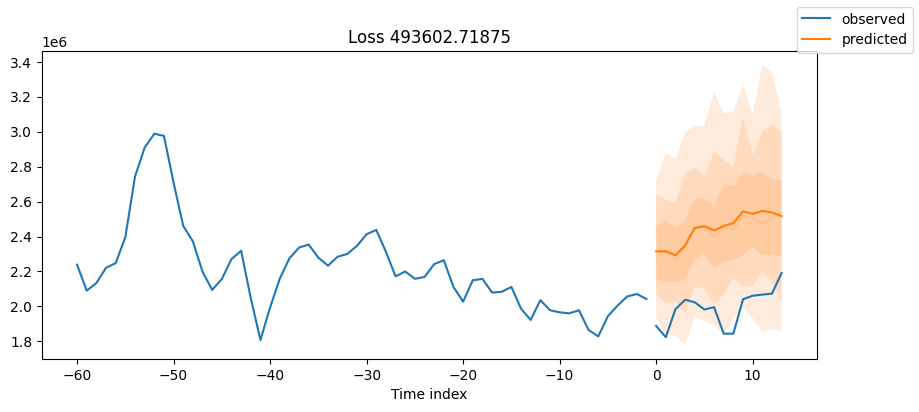

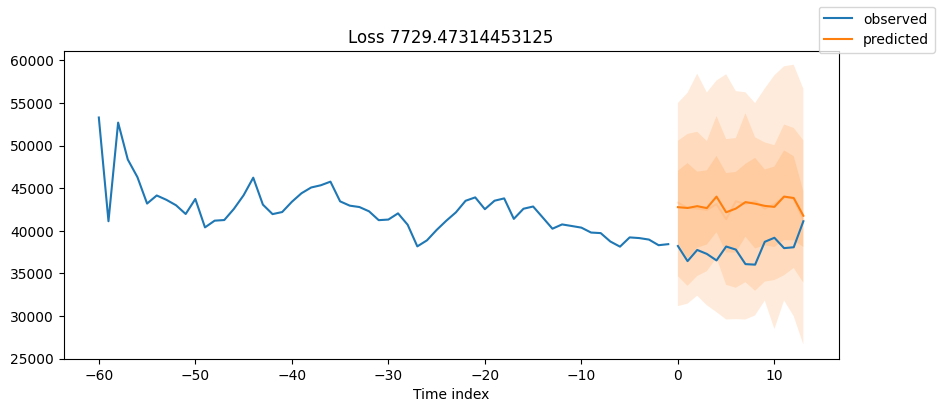

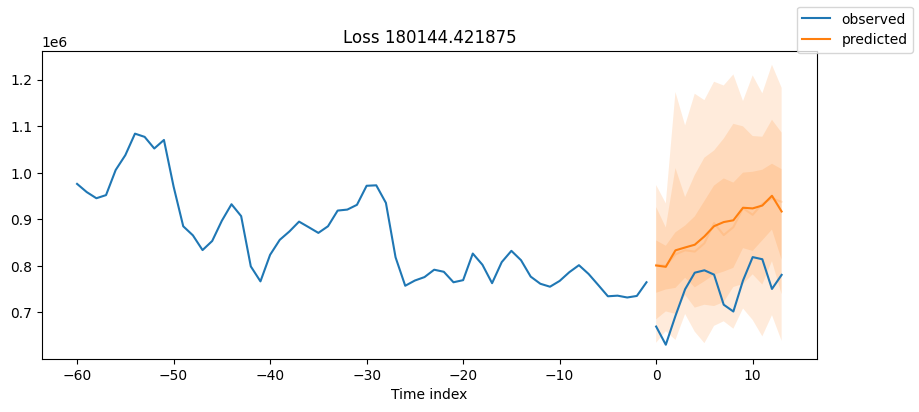

In [39]:
for idx in range(8):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)


In [40]:
# import shutil
# shutil.rmtree("optuna_test")

In [41]:
"""
Hyperparameters can be efficiently tuned with `optuna <https://optuna.readthedocs.io/>`_.
"""

__all__ = ["optimize_hyperparameters"]

from loguru import logger
import copy
import logging
import os
from typing import Any, Dict, Tuple, Union, Optional, Callable, Type, Sequence

import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.tuner.lr_finder import _LRFinder
import numpy as np
import optuna
from optuna import Trial
from optuna.integration import PyTorchLightningPruningCallback
import optuna.logging
import statsmodels.api as sm
from torch import Tensor
from torch.utils.data import DataLoader

from pytorch_forecasting import TemporalFusionTransformer, BaseModel
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss

optuna_logger = logging.getLogger("optuna")


NUMBER = Union[float, int]


class PyTorchLightningPruningCallbackAdjusted(PyTorchLightningPruningCallback):  # type: ignore
    """Need to inherit from callback for this to work."""


def input_params_generator_tft(
    trial: Trial,
    hidden_size_range: Tuple[int, int] = (16, 265),
    hidden_continuous_size_range: Tuple[int, int] = (8, 64),
    attention_head_size_range: Tuple[int, int] = (1, 4),
    dropout_range: Tuple[float, float] = (0.1, 0.3),
) -> dict:
    """Generates parameters for `TemporalFusionTransformer`."""
    hidden_size = trial.suggest_int("hidden_size", *hidden_size_range, log=True)
    dropout = trial.suggest_uniform("dropout", *dropout_range)
    hidden_continuous_size = trial.suggest_int(
        "hidden_continuous_size",
        hidden_continuous_size_range[0],
        min(hidden_continuous_size_range[1], hidden_size),
        log=True,
    )
    attention_head_size = trial.suggest_int("attention_head_size", *attention_head_size_range)
    params = dict(
        hidden_size=hidden_size,
        dropout=dropout,
        hidden_continuous_size=hidden_continuous_size,
        attention_head_size=attention_head_size,
    )
    return params


def optimize_hyperparameters(
    train_dataloaders: DataLoader,
    val_dataloaders: DataLoader,
    model_path: str = "hpo",
    monitor: str = "val_loss",
    direction: str = "minimize",
    model_class: Type[BaseModel] = TemporalFusionTransformer,
    max_epochs: int = 20,
    n_trials: int = 100,
    timeout: float = 3600 * 8.0,  # 8 hours
    gradient_clip_val_range: Tuple[float, float] = (0.01, 100.0),
    input_params: Dict[str, Dict[str, Any]] = None,
    input_params_generator: Callable = None,
    generator_params: dict = {},
    learning_rate_range: Tuple[float, float] = (1e-5, 1.0),
    use_learning_rate_finder: bool = True,
    trainer_kwargs: Dict[str, Any] = {},
    log_dir: str = "lightning_logs",
    study: optuna.Study = None,
    verbose: Union[int, bool] = None,
    pruner: optuna.pruners.BasePruner = optuna.pruners.SuccessiveHalvingPruner(),
    **kwargs: Any,
) -> optuna.Study:
    """
    Optimize hyperparameters. Run hyperparameter optimization. Learning rate for is determined with the PyTorch Lightning learning rate finder.

    Args:
        train_dataloaders (DataLoader):
            Dataloader for training model.
        val_dataloaders (DataLoader):
            Dataloader for validating model.
        model_path (str):
            Folder to which model checkpoints are saved.
        monitor (str):
            Metric to return. The hyper-parameter (HP) tuner trains a model for a certain HP config, and reads this metric to score configuration. By default, the lower the better.
        direction (str):
            By default, direction is "minimize", meaning that lower values of the specified `monitor` are better. You can change this, e.g. to "maximize".
        max_epochs (int, optional):
            Maximum number of epochs to run training. Defaults to 20.
        n_trials (int, optional):
            Number of hyperparameter trials to run. Defaults to 100.
        timeout (float, optional):
            Time in seconds after which training is stopped regardless of number of epochs or validation metric. Defaults to 3600*8.0.
        input_params (dict, optional):
            A dictionary, where each `key` contains another dictionary with two keys: `"method"` and `"ranges"`. Example:
                >>> {"hidden_size": {
                >>>     "method": "suggest_int",
                >>>     "ranges": (16, 265),
                >>> }}
            The method key has to be a method of the `optuna.Trial` object. The ranges key are the input ranges for the specified method.
        input_params_generator (Callable, optional):
            A function with the following signature: `fn(trial: optuna.Trial, **kwargs: Any) -> Dict[str, Any]`, returning the parameter values to set up your model for the current trial/run.
            Example:
                >>> def fn(trial: optuna.Trial, param_ranges: Tuple[int, int] = (16, 265)) -> Dict[str, Any]:
                >>>     param = trial.suggest_int("param", *param_ranges, log=True)
                >>>     model_params = {"param": param}
                >>>     return model_params
            Then, when your model is created (before training it and report the metrics for the current combination of hyperparameters), these dictionary is used as follows:
                >>> model = YourModelClass.from_dataset(
                >>>     train_dataloaders.dataset,
                >>>     log_interval=-1,
                >>>     **model_params,
                >>> )
        generator_params (dict, optional):
            The additional parameters to be passed to the `input_params_generator` function, if required.
        learning_rate_range (Tuple[float, float], optional):
            Learning rate range. Defaults to (1e-5, 1.0).
        use_learning_rate_finder (bool):
            If to use learning rate finder or optimize as part of hyperparameters. Defaults to True.
        trainer_kwargs (Dict[str, Any], optional):
            Additional arguments to the `PyTorch Lightning trainer <https://pytorch-lightning.readthedocs.io/en/latest/trainer.html>` such as `limit_train_batches`. Defaults to {}.
        log_dir (str, optional):
            Folder into which to log results for tensorboard. Defaults to "lightning_logs".
        study (optuna.Study, optional):
            Study to resume. Will create new study by default.
        verbose (Union[int, bool]):
            Level of verbosity.
                * None: no change in verbosity level (equivalent to verbose=1 by optuna-set default).
                * 0 or False: log only warnings.
                * 1 or True: log pruning events.
                * 2: optuna logging level at debug level.
            Defaults to None.
        pruner (optuna.pruners.BasePruner, optional):
            The optuna pruner to use. Defaults to `optuna.pruners.SuccessiveHalvingPruner()`.
        **kwargs:
            Additional arguments for your model's class.

    Returns:
        optuna.Study: optuna study results
    """
    assert isinstance(train_dataloaders.dataset, TimeSeriesDataSet) and isinstance(
        val_dataloaders.dataset, TimeSeriesDataSet
    ), "Dataloaders must be built from TimeSeriesDataSet."

    logging_level = {
        None: optuna.logging.get_verbosity(),
        0: optuna.logging.WARNING,
        1: optuna.logging.INFO,
        2: optuna.logging.DEBUG,
    }
    optuna_verbose = logging_level[verbose]
    optuna.logging.set_verbosity(optuna_verbose)

    # need a deepcopy of loss as it will otherwise propagate from one trial to the next
    loss = kwargs.get("loss", None)

    # create objective function
    def objective(trial: optuna.Trial) -> float:
        # Filenames for each trial must be made unique in order to access each checkpoint
        checkpoint_callback = ModelCheckpoint(
            dirpath=os.path.join(model_path, f"trial_{trial.number}"),
            filename="{epoch}",
            monitor=monitor,
        )
        # Create Trainer
        learning_rate_callback = LearningRateMonitor()
        gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
        default_trainer_kwargs = dict(
            accelerator="auto",
            max_epochs=max_epochs,
            gradient_clip_val=gradient_clip_val,
            callbacks=[
                learning_rate_callback,
                checkpoint_callback,
                PyTorchLightningPruningCallbackAdjusted(trial, monitor=monitor),
            ],
            logger=TensorBoardLogger(log_dir, name="optuna", version=trial.number),
            enable_progress_bar=optuna_verbose < optuna.logging.INFO,
            enable_model_summary=[False, True][optuna_verbose < optuna.logging.INFO],
        )
        default_trainer_kwargs.update(trainer_kwargs)
        trainer = pl.Trainer(**default_trainer_kwargs)  # type: ignore
        # Create model: set up kwargs
        if input_params_generator is None:
            assert (
                input_params is not None
            ), "Please provide `input_params` when not providing a `input_params_generator` function."
            params = dict()
            for key, cfg in input_params.items():
                fn, low, high, more_kwargs = extract_params(trial, cfg)
                try:
                    params[key] = fn(key, low, high, **more_kwargs)
                except ValueError as ex:
                    raise ValueError(f"Error while calling {fn} for {key}.") from ex
        else:
            params = input_params_generator(trial, **generator_params)
        kwargs.update(params)
        kwargs["loss"] = copy.deepcopy(loss)
        # Create model
        logger.trace(f"Creating model with {kwargs.keys()}")
        model = model_class.from_dataset(
            train_dataloaders.dataset,
            log_interval=-1,
            **kwargs,
        )
        # find a good learning rate
        if use_learning_rate_finder:
            lr_trainer = pl.Trainer(
                gradient_clip_val=gradient_clip_val,
                accelerator=trainer_kwargs.get("accelerator", "auto"),
                logger=False,
                enable_progress_bar=False,
                enable_model_summary=False,
            )
            tuner = Tuner(lr_trainer)
            res: Optional[_LRFinder] = tuner.lr_find(
                model,
                train_dataloaders=train_dataloaders,
                val_dataloaders=val_dataloaders,
                early_stop_threshold=10000,
                min_lr=learning_rate_range[0],
                num_training=100,
                max_lr=learning_rate_range[1],
            )
            assert res is not None, "`tuner.lr_find()` return no results."
            loss_finite = np.isfinite(res.results["loss"])
            if loss_finite.sum() > 3:  # at least 3 valid values required for learning rate finder
                lr_smoothed, loss_smoothed = sm.nonparametric.lowess(
                    np.asarray(res.results["loss"])[loss_finite],
                    np.asarray(res.results["lr"])[loss_finite],
                    frac=1.0 / 10.0,
                )[min(loss_finite.sum() - 3, 10) : -1].T
                optimal_idx = np.gradient(loss_smoothed).argmin()
                optimal_lr = lr_smoothed[optimal_idx]
            else:
                optimal_idx = np.asarray(res.results["loss"]).argmin()
                optimal_lr = res.results["lr"][optimal_idx]
            optuna_logger.info(f"Using learning rate of {optimal_lr:.3g}")
            # add learning rate artificially
            model.hparams.learning_rate = trial.suggest_uniform("learning_rate", optimal_lr, optimal_lr)
        else:
            model.hparams.learning_rate = trial.suggest_loguniform("learning_rate", *learning_rate_range)
        # fit
        trainer.fit(model, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders)
        # report result: choose logged metric
        metrics: dict = trainer.callback_metrics
        logger.trace(f"Available metrics: {metrics.keys()}")
        try:
            metric_value: Tensor = metrics[monitor]
        except KeyError as ex:
            raise KeyError(f"Available metrics: {metrics.keys()}") from ex
        return metric_value.item()

    # setup optuna and run
    if study is None:
        study = optuna.create_study(direction=direction, pruner=pruner)
        loss = kwargs.get("loss", None)
        
    study.optimize(objective, n_trials=n_trials, timeout=timeout)
    return study


def extract_params(
    trial: Trial,
    cfg: Dict[str, Any],
) -> Tuple[Callable, NUMBER, NUMBER, Dict[str, Any]]:
    """Helper to extract config for one hp."""
    more_kwargs: Dict[str, Any] = {}
    for k, v in cfg.items():
        if k.lower() in ["method"]:
            method: str = cfg["method"]
            assert isinstance(method, str), f"You must provide a {str} as method."
            fn: Callable = getattr(trial, method)
        elif k.lower() in ["ranges"]:
            ranges: Sequence[NUMBER] = cfg["ranges"]
            assert isinstance(ranges, (list, tuple)), f"You must provide a {list} or {tuple} as ranges."
            assert len(ranges) == 2, f"Why did you provide {len(ranges)} values? Only provide 2."
            low = ranges[0]
            high = ranges[1]
        else:
            more_kwargs[k.lower()] = v
    return fn, low, high, more_kwargs

In [44]:
input_params = {
    "hidden_size": {"method": "suggest_int", "ranges": (64, 512)},
    #"hidden_continuous_size": {"method": "suggest_int", "ranges": (30, 128)},
    #"attention_head_size": {"method": "suggest_int", "ranges": (1, 4)},
    "dropout": {"method": "suggest_uniform", "ranges": (0.1, 0.5)},
}

study = optimize_hyperparameters(
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    model_path="optuna_test",
    n_trials=7,
    model_class=DeepAR,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    input_params=input_params,  # Add this line
    learning_rate_range=(0.0001, 0.2),
    use_learning_rate_finder=True,
    verbose=0
)


# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 99 steps due to diverging loss.
INFO: Learning rate set to 0.011133676474718055
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_4e5e2007-2323-4c86-996e-d781753cf95c.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_4e5e2007-2323-4c86-996e-d781753cf95c.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/optuna_test/trial_0 exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(dev

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0060611662687812965
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_eece3320-86e5-48ec-8e92-50635595487f.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_eece3320-86e5-48ec-8e92-50635595487f.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/optuna_test/trial_1 exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0028343481724362675
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_dcdbdced-cb5e-4eef-bf66-10869a2d55cc.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_dcdbdced-cb5e-4eef-bf66-10869a2d55cc.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/optuna_test/trial_2 exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebo

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0129616173817609
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_3bfe533f-8a58-4367-8ad4-236ce7915ea0.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_3bfe533f-8a58-4367-8ad4-236ce7915ea0.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0014300805449788993
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_d21ca176-7b11-4506-b34c-51a42f076deb.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_d21ca176-7b11-4506-b34c-51a42f076deb.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INF

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0022564322499053656
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_86b13c46-4434-4c3b-8942-330e36d7bade.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_86b13c46-4434-4c3b-8942-330e36d7bade.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INF

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005617536432335246
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_66fb635f-79c7-4558-b84c-cda5435521f8.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_66fb635f-79c7-4558-b84c-cda5435521f8.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'gradient_clip_val': 0.01612447494148756, 'hidden_size': 94, 'dropout': 0.4600241643737374, 'learning_rate': 0.012012928640327802}


In [45]:
#study.best_trial.params => {'gradient_clip_val': 0.0497323505537481, 'hidden_size': 347, 'dropout': 0.20041065991700943, 'learning_rate': 0.009563524997900369}
trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=study.best_trial.params['gradient_clip_val'],
    #callbacks=[lr_logger],
     callbacks=[early_stop_callback],
     enable_checkpointing=True,
    logger=neptune_logger)

net = DeepAR.from_dataset(
    training,
    learning_rate=study.best_trial.params['learning_rate'],
    log_interval=10,
    dropout=study.best_trial.params['dropout'],
    log_val_interval=1,
    hidden_size=study.best_trial.params['hidden_size'],
    rnn_layers=2,
    #loss=MultivariateNormalDistributionLoss(rank=30),
)
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/deepar/__init__.py:146: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default o

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 49.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_step. Invalid point: 49.0


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.009 >= min_delta = 1e-05. New best score: 11.295


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 90.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 90.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 90.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 90.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 90.0
[neptune] [error  ] Error occurred during asynchronous operation proce

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.131 >= min_delta = 1e-05. New best score: 11.164


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 181.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 181.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 181.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MASE. Invalid point: 181.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 181.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 272.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 272.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 272.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 272.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MASE. Invalid point: 272.0
[neptune] [error  ] Error occurred during asynchronous operation pr

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 363.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 363.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 363.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MASE. Invalid point: 363.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 363.0
[neptune] [error  ] Error occurred during asynchronous operati

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 454.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 454.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 454.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 454.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 454.0
[neptune] [error  ] Error occurred during asynchrono

Validation: |          | 0/? [00:00<?, ?it/s]

[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 545.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 545.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAE. Invalid point: 545.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 545.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/epoch. Invalid point: 545.0
[neptune] [error  ] Error occurred during asynchronous operatio

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 11.164. Signaling Trainer to stop.


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/train_loss_epoch. Invalid point: 636.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_RMSE. Invalid point: 636.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_SMAPE. Invalid point: 636.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_loss. Invalid point: 636.0
[neptune] [error  ] Error occurred during asynchronous operation processing: X-coordinates (step) must be strictly increasing for series attribute: training/val_MAPE. Invalid point: 636.0
[neptune] [error  ] Error occurred during asynchron

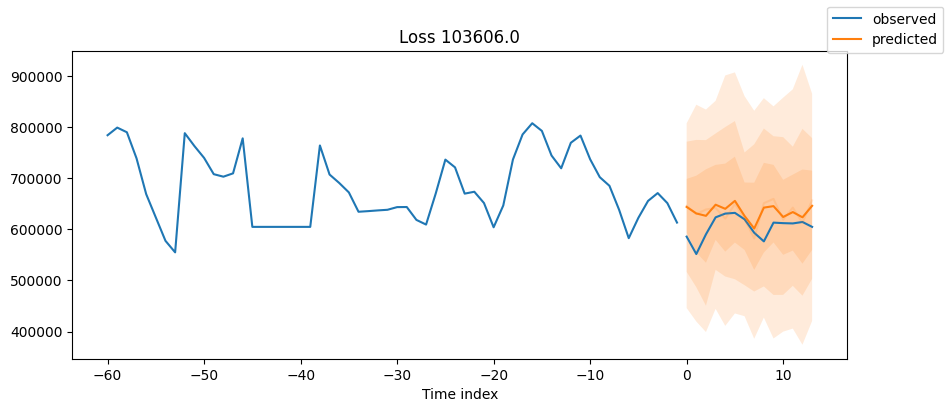

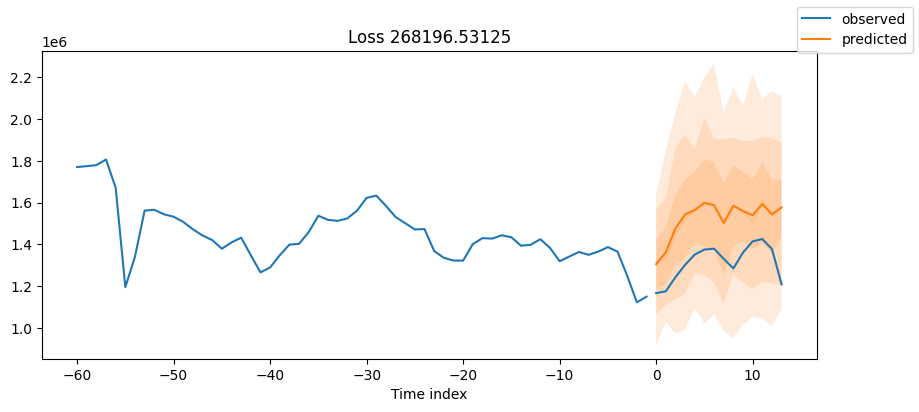

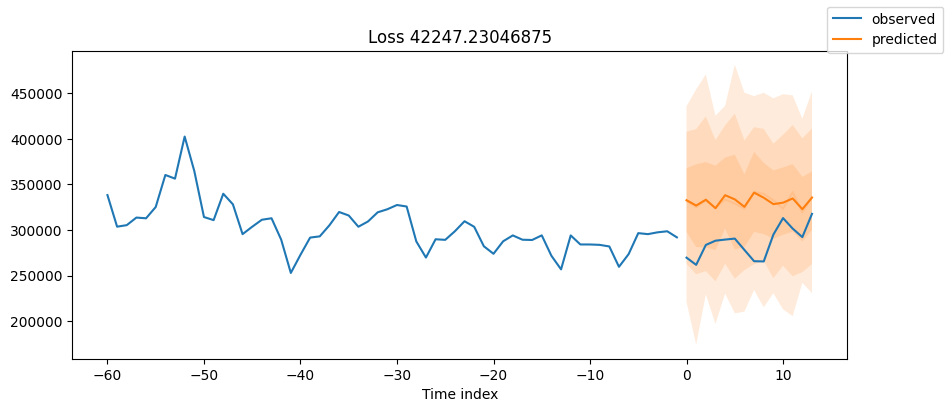

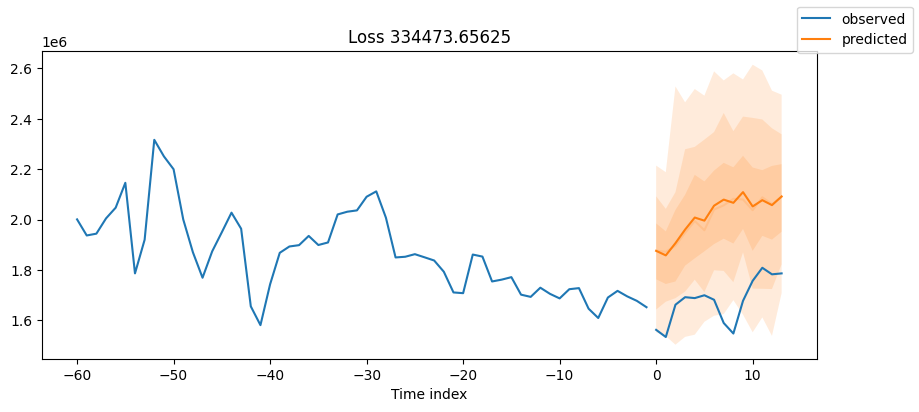

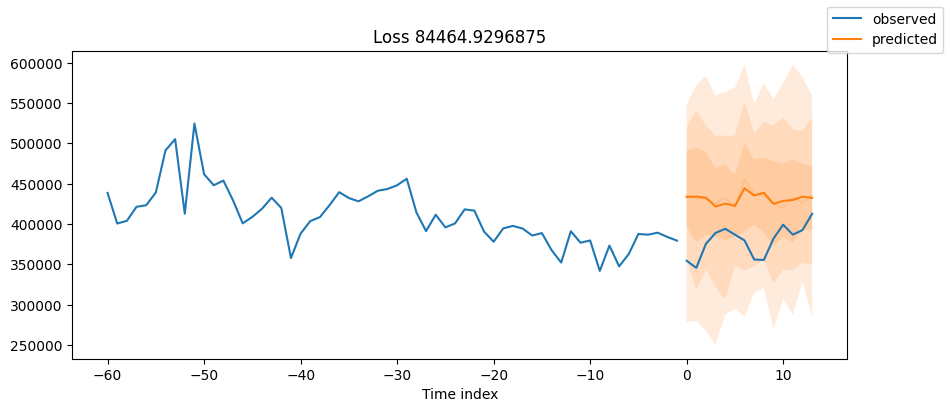

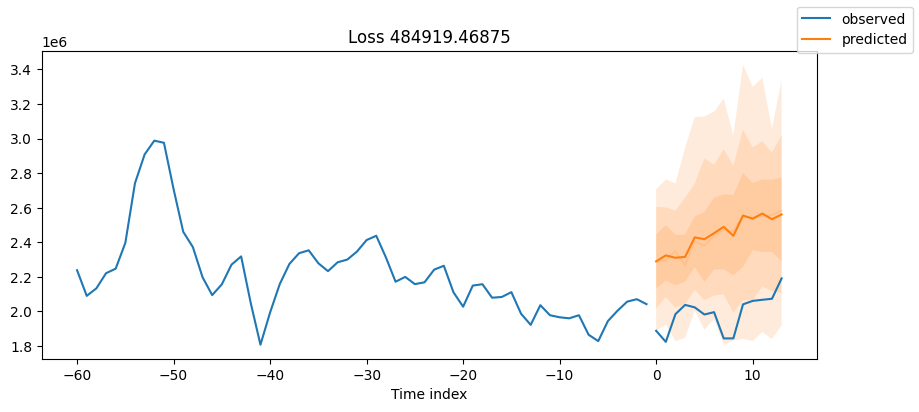

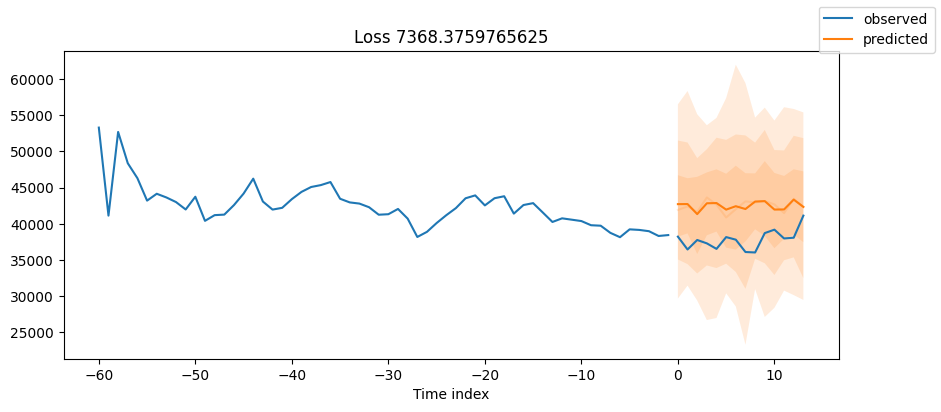

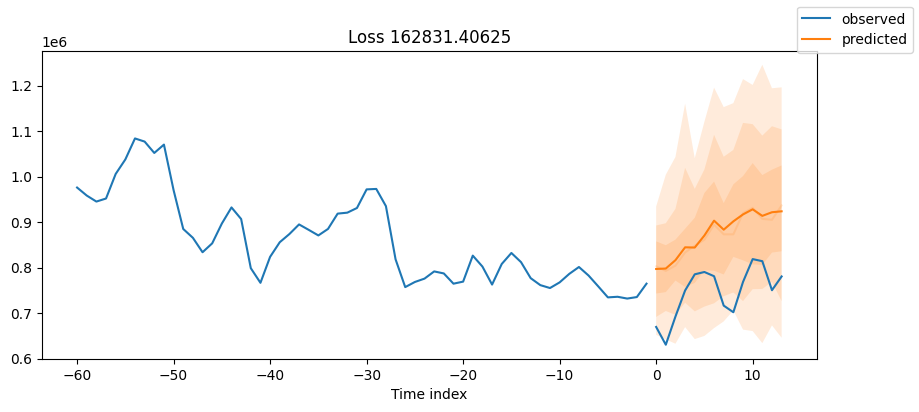

In [46]:
raw_predictions=best_model.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(8):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)